# Exploring City of San Diego Special Event Permiting dataset

San Diego has been leading the charge when in opening and providing open city data. This data can be found at https://data.sandiego.gov. 

For this Friday Exporlation Challegne we're exploring the Special Events permiting dataset of San Diego. In order for special events to host an event on public property you need to apply for a special permit. So lets get down to exploring.

## Alex's Exploration:
Let's Explore San Diego's Special Event Permitting Dataset! I found this data on San Diego's Open Data Portal and wanted to take a crack at exploring the data. All Data has a story. Let's find it.

Questions I am looking to answer:
- Who has hosted the most event in San Diego over the past few years? (Frequency Count)
- What is the most common types of special events?(Frequency Count and Topic Analysis)
    - Compare the frequency of certain types of special events occuring?
    - Conduct a topic analysis on the given event descriptions.
- When did the majority of these events take place? (Kind of Time Series)
- What is the distribution of participants and attendees for the Special Events? (Distribution)
- What is the geographical distribution of specially permitted events in san diego? (GIS)
    - Is there geographical clustering of certain types of events? (GIS and Clustering)

In [19]:
import re
import folium
import tldextract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# reading the special event data into a pandas dataframe
df = pd.read_csv('../data/special_events_list_datasd.csv')

In [2]:
len(df)

2769

In [3]:
df.dtypes

event_title          object
event_id              int64
event_subtitle      float64
event_type           object
event_desc           object
event_loc            object
event_start          object
event_end            object
exp_attendance       object
exp_participants     object
event_host           object
event_url            object
event_address        object
latitude            float64
longitude           float64
dtype: object

In [4]:
print (df.isnull().sum())

event_title            0
event_id               0
event_subtitle      2769
event_type             0
event_desc             0
event_loc              0
event_start            0
event_end              0
exp_attendance        21
exp_participants      41
event_host             1
event_url            533
event_address        168
latitude             184
longitude            184
dtype: int64


# Data Cleaning

Before we can explore the data we need to process the event_urls and clean the host_names. I am doing this so i am can get a rough estimate of how many events and individual event_host has hosted. Additionally, it's good practice to clean text data before getting into any indepth anaylsis.

In [5]:
def cleaning_names(string):
    """
        Overview: This function is responsible for cleaning the text data from the special event permiting 
        event.
    """
    string = re.sub(r'[\',-./]|\sBD',r'', string)
    return string.strip().lower()

def url_processing(df):
    """
        Overview: This function is responsible for cleaning and separating the event Urls from the special
        permit dataset. The purpose of this is to identify organizations that have hosted multiple events.
        
        Input:
            - df: pandas dataframe the of special permit dataset.
        
        Output:
            - domain: a list containing the url domains 
            - suffix: a list containing the url suffix
    """
    domain = []
    suffix = []
    
    for url in df.event_url.values:
        try:
            processed = tldextract.extract(url)
            domain.append(processed.domain)
            suffix.append(processed.suffix)
        except:
            domain.append(np.nan)
            suffix.append(np.nan)
    
    return domain, suffix

In [6]:
# what does the data look like
df = df[df['event_host'].notnull()]
df['event_host'] = df['event_host'].apply(cleaning_names)
df['event_domain'], df['event_suffix'] = url_processing(df)

df.head()

,event_title,event_id,event_subtitle,event_type,event_desc,event_loc,event_start,event_end,exp_attendance,exp_participants,event_host,event_url,event_address,latitude,longitude,event_domain,event_suffix
0,Sunday Artisan Market,50588,NaN,FARMERS,The Sunday Artisan Market provides space for l...,5th Avenue between Market Street and Island Av...,2018-12-30 10:00:00,2018-12-30 15:00:00,"3,000",20,gaslamp quarter association,www.gaslamp.org,5th Avenue & Market Street,32.731392,-117.160285,gaslamp,org
1,Old Town Artisan's Market,50424,NaN,FARMERS,A weekend open air market offering an array of...,Harney Street between San Diego Avenue and Con...,2018-12-30 09:00:00,2018-12-30 16:30:00,"1,000",100,old town san diego chamber of commerce,NaN,Harney Street & San Diego Avenue,32.752779,-117.194902,NaN,NaN
2,2018 Hillcrest Farmers' Market (Sundays),49953,NaN,FARMERS,This farmer's market in Hillcrest offers an ar...,DMV parking lot at 3690 Normal Street ~ Normal...,2018-12-30 09:00:00,2018-12-30 14:00:00,"2,000",400,hillcrest business association,www.hillcrestfarmersmarket.com,3690 Normal Street,32.748542,-117.149901,hillcrestfarmersmarket,com
3,Old Town Artisan's Market,50423,NaN,FARMERS,A weekend open air market offering an array of...,Harney Street between San Diego Avenue and Con...,2018-12-29 09:00:00,2018-12-29 16:30:00,"1,000",100,old town san diego chamber of commerce,NaN,Harney Street & San Diego Avenue,32.752779,-117.194902,NaN,NaN
4,City Heights Farmer's Market (Every Saturday),50130,NaN,FARMERS,This farmer's market in City Heights offers an...,Wightman Street between 43rd Street and Fairmo...,2018-12-29 09:00:00,2018-12-29 13:00:00,500,100,san diego county farm bureau,www.sdfarmbureau.org,Wightman & 43rd Streets,32.747753,-117.099983,sdfarmbureau,org


# Who host the most events requiring a special permit?

Now that I have finished processing and cleaning the special permitting data. Let's find out what organizations have hosted the most special events in our special permit dataset. 

## Host Frequency Count Protocol
In order to find out which organization has hosted the most events we need a frequency count. I am calculating frequency count utilizing the pandas dataframe groupby size for both records with and without a url. 

If a record has a url we run the groupby on the event_domain column. If the records is missing the url utilize the event_host column for the groupby. This will generate to pandas series with frequency counts for each unique domain name and host name. Once these pandas series are generated we append them together and sort by decsending order. Then plot the top 20 values of these pandas series in a bar chart with them.

## Result
The **majority of the top 20 hosts of special events are farmer markets** in various different nieghborhoods of san diego.
More specifically the organization that hosts the most events is **Little Italy's Mercato Farmers’ Market.** 

In [7]:
# Get the frequency count of all events with a domain and then if url was null
# count the frequency a host name occurred
host_counts = df[df.event_domain.notnull()].groupby(['event_domain']).size()
counts_null_host = df[df.event_domain.isnull()].groupby(['event_host']).size()
# append the counts counted via url domain to the count based on host names that have no provided url
host_counts.append(counts_null_host)
host_counts.sort_values(ascending=False, inplace=True)

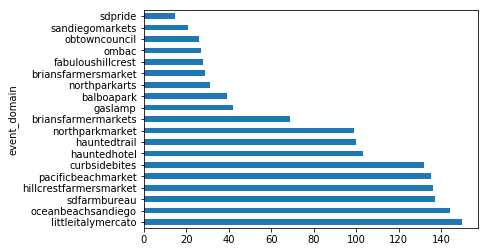

In [8]:
# graphing the top twenty organizations that host the majority of the events.
host_counts[:19].plot.barh()

# What are the most common types of special events in San Diego?

Now that we have identified that farmer markets host doesn't mean that farm markets are actually the most common event. Or that there isn't a predominate sub-type of farmer markets that are the majority of special events. In order to identify that we need to first compare the frequency counts of different special event types. After comparing those counts we then need to try and identify sub groups by conducting a topic analysis on the event descriptions. 


## Event Type Frequence Count Protocol
NEED TO WRITE IT DOWN

## Event Description Topic Analysis Protocol
NEED TO WRITE IT DOWN

## Results:
- Frequency of Event Type:
    - we can confirm the most frequent special event are farmers markets. Followed by Festivals and then Altheltic (most likely padre games)
- What are the sub groups of these event types?

event_type
FARMERS     1472
FESTIVAL     752
ATHLETIC     415
PARADES       54
CONCERTS      47
EXHIBITS      23
MUSEUM         5
dtype: int64


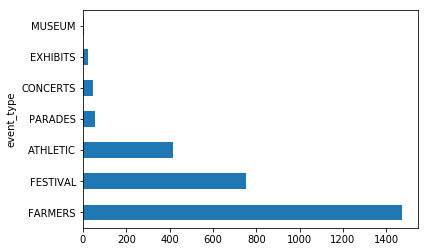

In [9]:
event_type_count = df.groupby(['event_type']).size() # lets get the frequency count for each event_type
event_type_count.sort_values(inplace=True, ascending=False) # sort the values in the pandas series by descending order
print (event_type_count) # lets see the frequency table
event_type_count.plot.barh() # plotting the frequency table as a horizontial bar plot.

In [10]:
# I am conducting a topic anaylsis. Because the dataset isn't too large 
# I am going to both LDA (bag of words) and NMF (works with tf-idf) and see 
# how they cluster after applying t-sne. t-sne results will be 3d and 2d.
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# setting my document corpus to event descriptions.
documents = df.event_desc.values

In [11]:
# converting the document corpus the either a bag of word or tf-idf matrix for topic analysis algorithms

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [12]:
# Setting the number of topics NMF and LDA are looking for.
# these alogrithms cannot autodetect different 
no_topics = 20
no_top_words = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_matrix = nmf.transform(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=0).fit(tf)
lda_matrix = lda.transform(tf)

/Users/alexanderbaker/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [13]:
# listing the topics identified by the two alogrithms
def display_topics(model, feature_names, no_top_words, alog_used='NULL'):
    print ("\nTopics for Topic Analysis Algorithm: {}".format(alog_used))
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}: {}".format(topic_idx, " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])))

    
display_topics(nmf, tfidf_feature_names, no_top_words, 'NMF')
display_topics(lda, tf_feature_names, no_top_words, 'LDA')


Topics for Topic Analysis Algorithm: NMF
Topic 0: items nuts ocean creations sauces beach bakery gift dry goodies
Topic 1: interesting weekend pottery air artists offering open clothing local art
Topic 2: north park oriented grown products providing locally gathering community healthy
Topic 3: farmers mercato herbs certified filled pastured chicken sizes shapes california
Topic 4: dare hotel inside haunted creatures undead creaky touch darkened slither
Topic 5: food menu serve lunchtime conveniently caravan wednesday pick choices quickly
Topic 6: forest walk shadows lurking hang darkness fingers dark eyes want
Topic 7: items asia latin southwest africa heights america imported east city
Topic 8: items seafood dairy hillcrest jewelry products clothing meat art dry
Topic 9: food plus friendly grown providing locally gathering healthy residents place
Topic 10: space provides local sunday retailers entertainers sell far artisans venue
Topic 11: 00 panama walkway parked evenings rotating d

In [14]:
# compressing the resulting matrix from NMF and LDA with T-SNE
from sklearn.manifold import TSNE
# compressing matrix into a 2-Dimensional space
nmf_embedded = TSNE(n_components=2).fit_transform(nmf_matrix)
lda_embedded = TSNE(n_components=2).fit_transform(lda_matrix)

# compressing matrix into a 3-Dimensional space
nmf_embedded = TSNE(n_components=3).fit_transform(nmf_matrix)
lda_embedded = TSNE(n_components=3).fit_transform(lda_matrix)

In [15]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='bakeralex664', api_key='a7vexR1Pli50bFWRXdJp')

In [16]:
# reusable functions related to generating figures both 2D and 3D

def gen_scatter(labels, data, y, x_label='Principal Component 1', 
               y_label='Principal Component 2', file='test_saving.png'):
    """
        Overview: gen_scatter is responsible for generating 2-Dimensional scatter plots. It does this by using 
        the matplotlib library.
        
        Inputs:
            - labels: a list/tuple of labels that are used to label the data in the generated figure
            - data: a numpy array representing the data that is being plotted
            - y: a numpy array that contains the labels of the x numpy array.
            - x_label: label for the x-axis
            - y_label: label for the y-axis
            - file: file path were saving the figure to.
    """
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(20,10))
        for lab in labels:
            plt.scatter(data[y==lab, 0],
                        data[y==lab, 1],
                        label=lab)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.tight_layout()
        plt.savefig(file)

def gen_3d_plotly(labels, data, y, skip_col='none', file='testing-3D.html'):
    """
        Overview: gen_3d_plotly is responsible for generating 3-Dimensional scatter plots. It does this by using 
        the plotly library.
        
        Inputs:
            - labels: a list/tuple of labels that are used to label the data in the generated figure
            - data: a numpy array representing the data that is being plotted
            - y: a numpy array that contains the labels of the x numpy array.
            - file: file path were saving the figure to.
    """
    
    traces = []
    for lab in labels:
        
        if lab in skip_col:
            continue
        
        trace = go.Scatter3d(
            x=data[y==lab, 0],
            y=data[y==lab, 1],
            z=data[y==lab, 2],
            name=lab,
            mode='markers')
        
        traces.append(trace)

    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=traces, layout=layout)
    plot(fig, filename=file)
    iplot(fig, filename=file)

In [17]:
gen_3d_plotly(list(df.event_type.unique()), nmf_embedded, df.event_type.values)

In [18]:
gen_3d_plotly(list(df.event_type.unique()), lda_embedded, df.event_type.values)

In [24]:
df = df[df.latitude.notnull()]
df = df[df.longitude.notnull()]
lat_long = df[['latitude', 'longitude']]

In [25]:
folium_map = folium.Map(
    location=[48, -102],
    zoom_start=3,
    tiles="CartoDB dark_matter")

for coord in lat_long.values:
    # Loop thru cordinates
    folium.CircleMarker(
        location = [coord[0],coord[1]],
        radius = 1,
        # popup = df.iloc[count]['company_name'],
        color = '#3186cc',
        fill_color='#3186cc',
       ).add_to(folium_map)
    
# Displays map
folium_map